In [136]:
import sys
sys.path.append('../..')
from torchdyn.models import *; from torchdyn.datasets import *
device = torch.device('cuda')
import matplotlib.pyplot as plt

## Load

In [138]:
class HybridNeuralDE(nn.Module):
    def __init__(self, jump, flow, out, hidden_size, last_output=True, reverse=False):
        super().__init__()
        self.flow, self.jump, self.out = flow, jump, out
        self.hidden_size, self.last_output = hidden_size, last_output
        self.reverse = reverse
        
    def forward(self, x):
        h, c = self._init_latent(x[0])
        Y = []
        if self.reverse: x_t = x_t.flip(0)
        for i, x_t in enumerate(x): 
            h, c = self.jump(x_t, (h, c))
            h = self.flow(h)
            if self.out: out = self.out(h) 
            else: out = h
            Y.append(out[None])
        Y = torch.cat(Y)
        return Y[-1] if self.last_output else Y
        
    def _init_latent(self, x):
        h = torch.zeros((x.shape[0], self.hidden_size)).to(x.device)
        c = torch.zeros((x.shape[0], self.hidden_size)).to(x.device)
        return h, c

In [139]:
class LatentNeuralDE(nn.Module):
    def __init__(self, encoder, decoder, out):
        super().__init__()
        self.encoder, self.decoder, self.out = encoder, decoder, out
        
    def forward(self, x, s_span):
      
        z = self.encoder(x)
 
        z, qz0_mean, qz0_logvar = self.reparametrize(z)
        
        decoded_traj = self.decoder.trajectory(z, s_span)
        
        outs = []
        for el in decoded_traj:
            outs += [self.out(el)[None]]
        return torch.cat(outs), qz0_mean, qz0_logvar
    
    def reparametrize(self, z):
        dim = z.shape[1] // 2
        qz0_mean, qz0_logvar = z[:, :dim], z[:, dim:]
        epsilon = torch.randn(qz0_mean.size()).to(z)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
        return z0, qz0_mean, qz0_logvar

In [140]:
# encoder
jump = nn.LSTMCell(input_size=2, hidden_size=16)
f = nn.Sequential(nn.Linear(16, 64),
                  nn.ELU(),
                  nn.Linear(64, 64),
                  nn.ELU(),
                  nn.Linear(64, 16))

flow = NeuralDE(f, solver='dopri5', atol=1e-3, rtol=1e-3, sensitivity='autograd')
out = nn.Sequential(nn.Linear(16, 64), nn.ReLU(), nn.Linear(64, 8))
encoder = HybridNeuralDE(jump, flow, out, 16)
  
# decoder
f = Stable(nn.Sequential(nn.Linear(4, 32),
                         nn.Softplus(),
                         nn.Linear(32, 32),
                         nn.Tanh(),
                         nn.Linear(32, 1)))
          
decoder = NeuralDE(f, solver='dopri5', atol=1e-3, rtol=1e-3, sensitivity='autograd')

# out 
out = nn.Sequential(nn.Linear(4, 64), nn.ReLU(), nn.Linear(64, 2))
model = LatentNeuralDE(encoder, decoder, out).to(device)

In [141]:
dicti = torch.load('model_no_readout')
model.load_state_dict(dicti)

<All keys matched successfully>

## Data

In [142]:
data = torch.load('data/data_small_more_masses')
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(data.transpose(0, 1))
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [143]:
data.shape

torch.Size([50, 50, 2])

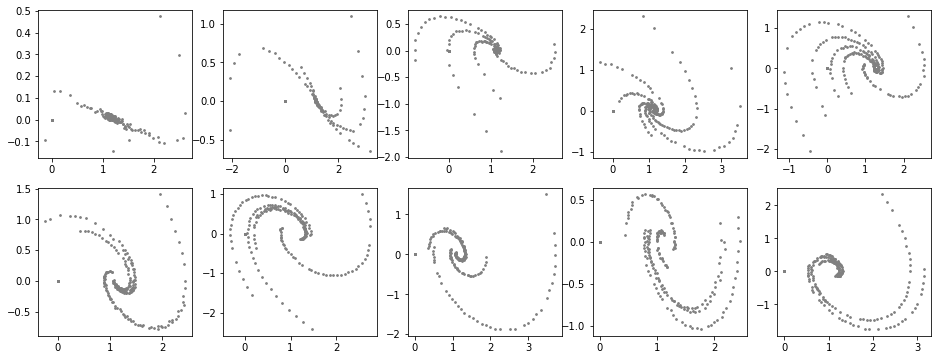

In [144]:
fig = plt.figure(figsize=(16, 6))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1+i)
    for j in range(5):
        ax.scatter(data[:,5*i+j,0], data[:,5*i+j,1], s=3, c='grey')

In [65]:
# for each slice (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ... 1.6, 1.7, 1.8, 1.9)
mass_span = torch.linspace(0.1, 1.9, 10)
K = 1
experiment = {}
for K in range(10):
    print(f'{K}')
    input_x = data[:,K*5:(K+1)*5]

    # obtain N samples
    N = 20
    idx = str(mass_span[K])
    experiment[idx] = {}
    experiment[idx]['pred'], experiment[idx]['qmu'], experiment[idx]['qlogvar'] = [], [], []
    for n in range(N):
        pred_x, qz0_mean, qz0_logvar = model(input_x[:, :100].to(device), torch.linspace(0, 5, 50))
        pred_x = pred_x.transpose(0, 1)
        pred_x = pred_x.detach().cpu()
        experiment[idx]['pred'] += [pred_x]
        experiment[idx]['qmu'] += [qz0_mean]
        experiment[idx]['qlogvar'] += [qz0_logvar]

0
1
2
3
4
5
6
7
8
9


In [59]:
k = 
plt.figure(figsize=(10, 6))
plt.scatter(pred_x[k,:,0], pred_x[k,:,1], c='r', s=10, alpha=0.4)

a = input_x.detach().cpu()
plt.scatter(a[:,k,0], a[:,k,1], c='b',  s=8, alpha=0.4)

IndexError: index 5 is out of bounds for dimension 0 with size 5

<Figure size 720x432 with 0 Axes>

In [74]:
pred_samples = torch.cat([el[None] for el in experiment['tensor(0.1000)']['pred']])

In [101]:
pred_samples.shape

torch.Size([20, 5, 50, 2])

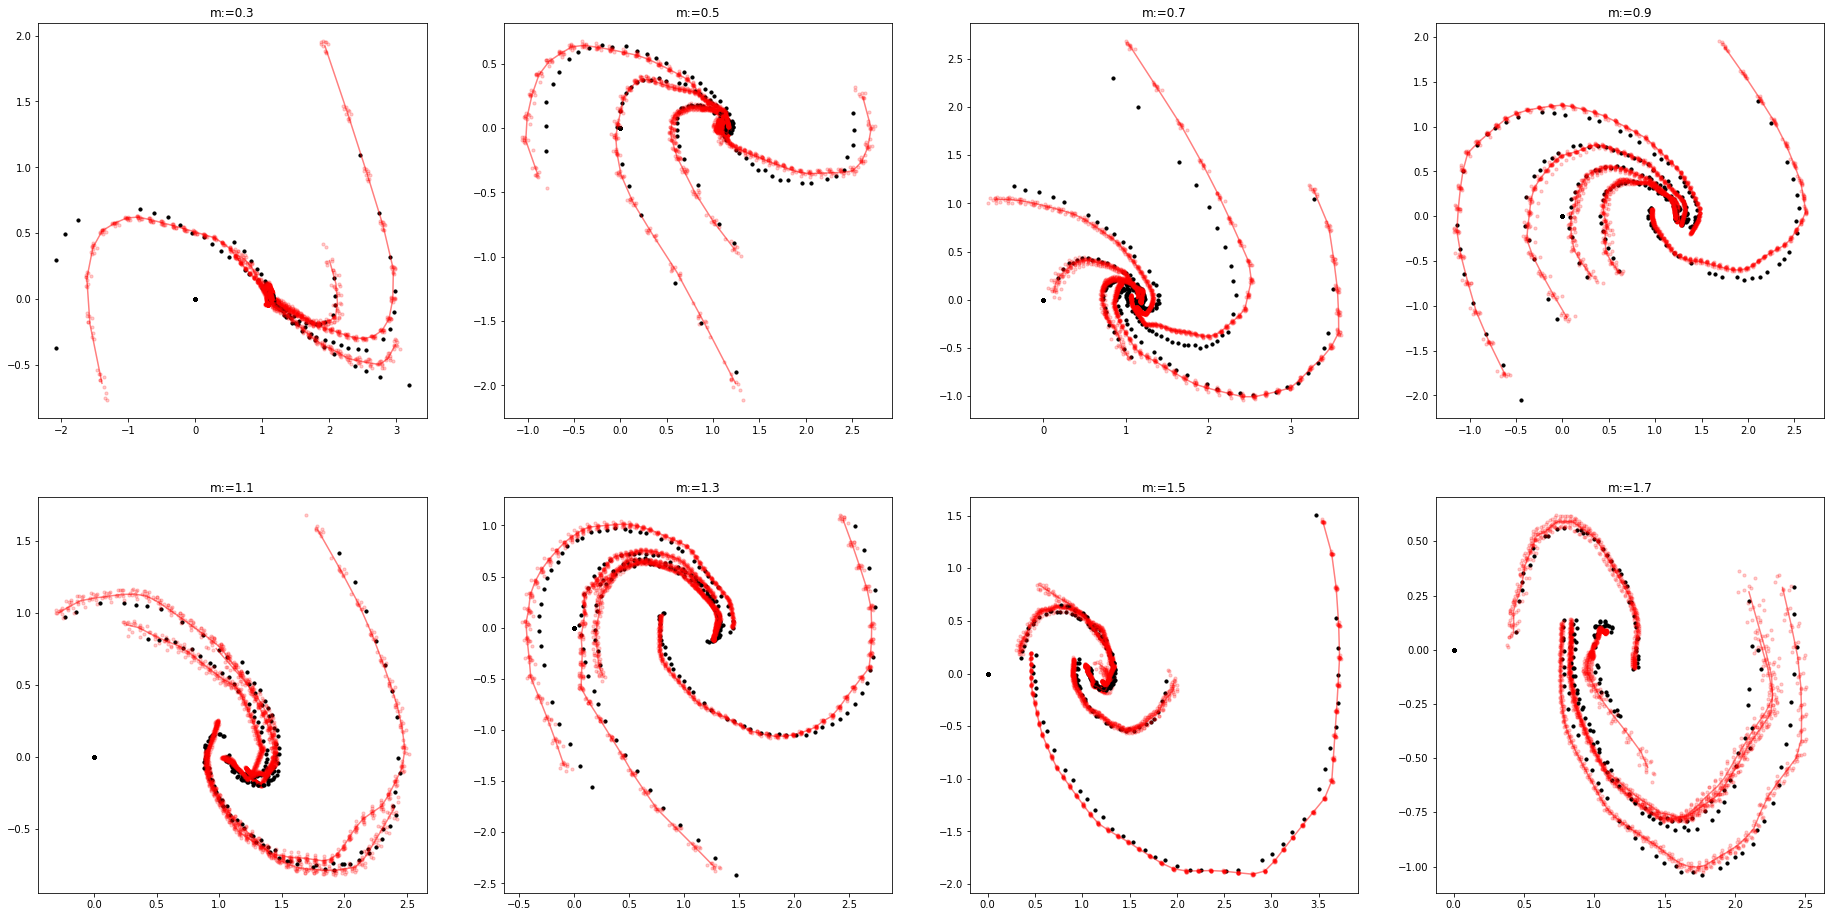

In [115]:
fig = plt.figure(figsize=(32, 16))
for i in range(1, 9):
    ax = fig.add_subplot(2, 4, 1+(i-1))
    for j in range(5):
        ax.scatter(data[:,5*i+j,0], data[:,5*i+j,1], s=10, c='black')
        idx = str(mass_span[i])
        pred_samples = torch.cat([el[None] for el in experiment[idx]['pred']])
        mean_pred = pred_samples.mean(0).transpose(0, 1)
        ax.plot(mean_pred[:,j,0], mean_pred[:,j,1], c='red', alpha=0.5)
        for a in range(10):
            ax.scatter(pred_samples[a,j,:,0], pred_samples[a,j,:,1], c='red', s=10, alpha=0.2)  
        ax.set_title(f'm:={mass_span[i].item():.1f}')

In [85]:
mass_span

tensor([0.1000, 0.3000, 0.5000, 0.7000, 0.9000, 1.1000, 1.3000, 1.5000, 1.7000,
        1.9000])

In [90]:
import math

In [129]:
K = 5
s_span = torch.linspace(0, 10, 50)
x = data[:,K*5:(K+1)*5].cuda()
z = model.encoder(x)
z, qz0_mean, qz0_logvar = model.reparametrize(z)
decoded_traj = model.decoder.trajectory(z, s_span).detach().cpu()

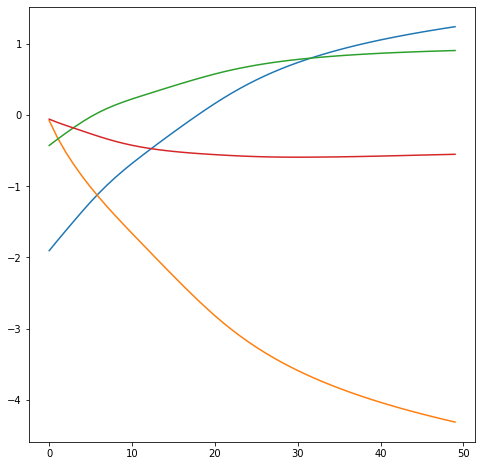

In [130]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(decoded_traj[:, 0, :])

### SHIT

In [145]:
# for each slice (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ... 1.6, 1.7, 1.8, 1.9)
mass_span = torch.linspace(0.1, 1.9, 10)
K = 1
experiment = {}
for K in range(10):
    print(f'{K}')
    input_x = data[:,K*5:(K+1)*5]

    # obtain N samples
    N = 2
    idx = str(mass_span[K])
    experiment[idx] = {}
    experiment[idx]['pred'], experiment[idx]['qmu'], experiment[idx]['qlogvar'] = [], [], []
    for n in range(N):
        pred_x, qz0_mean, qz0_logvar = model(input_x[:, :100].to(device), torch.linspace(0, 10, 100))
        pred_x = pred_x.transpose(0, 1)
        pred_x = pred_x.detach().cpu()
        experiment[idx]['pred'] += [pred_x]
        experiment[idx]['qmu'] += [qz0_mean]
        experiment[idx]['qlogvar'] += [qz0_logvar]

0
1
2
3
4
5
6
7
8
9


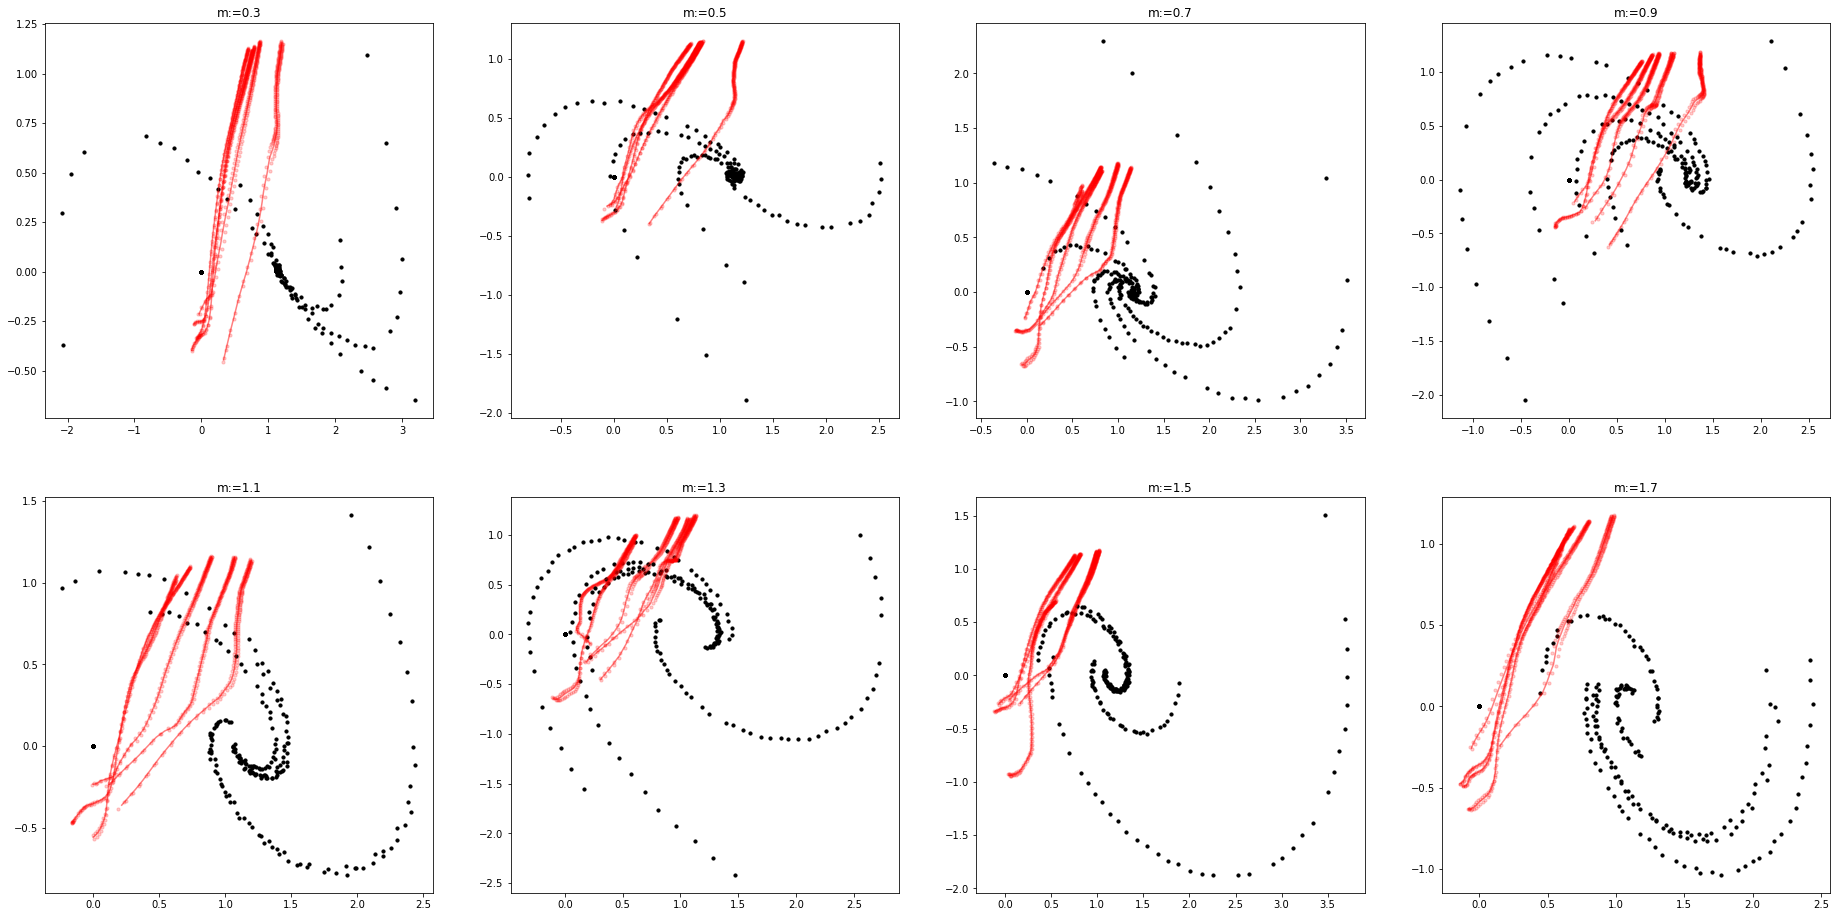

In [146]:
fig = plt.figure(figsize=(32, 16))
for i in range(1, 9):
    ax = fig.add_subplot(2, 4, 1+(i-1))
    for j in range(5):
        ax.scatter(data[:,5*i+j,0], data[:,5*i+j,1], s=10, c='black')
        idx = str(mass_span[i])
        pred_samples = torch.cat([el[None] for el in experiment[idx]['pred']])
        mean_pred = pred_samples.mean(0).transpose(0, 1)
        ax.plot(mean_pred[:,j,0], mean_pred[:,j,1], c='red', alpha=0.5)
        for a in range(2):
            ax.scatter(pred_samples[a,j,:,0], pred_samples[a,j,:,1], c='red', s=10, alpha=0.2)  
        ax.set_title(f'm:={mass_span[i].item():.1f}')